### import libiraries

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import string
# for Tokenization
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
# for removing accented and special chracters
import unicodedata
# for stopwords Removal
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
# for calculating Polarity and Subjectivity
from textblob import TextBlob
import plotly.express as px

In [2]:
dataset='../input/intent-classification-enfr/intent_classification.csv'
df=pd.read_csv(dataset)

# lets check the head of the dataset

In [3]:
df.head(10)

,text-en,intent-en,text-fr,intent-fr
0,can you walk me through setting up direct depo...,direct_deposit,pouvez-vous me guider à travers la mise en pla...,dépôt_direct
1,i want to switch to direct deposit,direct_deposit,Je veux passer au dépôt direct,dépôt_direct
2,set up direct deposit for me,direct_deposit,mettre en place le dépôt direct pour moi,dépôt_direct
3,how do i go about setting up direct deposit,direct_deposit,comment puis-je procéder pour mettre en place ...,dépôt_direct
4,i need to get my paycheck direct deposited to ...,direct_deposit,J’ai besoin d’obtenir mon chèque de paie dépos...,dépôt_direct
5,what are the steps to set up direct deposit to...,direct_deposit,quelles sont les étapes pour configurer le dép...,dépôt_direct
6,"if i would like to set up direct deposit, how ...",direct_deposit,si je souhaite mettre en place le dépôt direct...,dépôt_direct
7,how do i direct deposit my check,direct_deposit,comment puis-je déposer mon chèque directement,dépôt_direct
8,what do i need to set up direct deposit,direct_deposit,de quoi ai-je besoin pour mettre en place le d...,dépôt_direct
9,i'd like to have my paycheck direct deposited ...,direct_deposit,J’aimerais que mon chèque de paie soit déposé ...,dépôt_direct


In [4]:
df.shape

(15000, 4)

 # lets check if the dataset has any Missing Values

In [5]:
df.isnull()

,text-en,intent-en,text-fr,intent-fr
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
14995,False,False,False,False
14996,False,False,False,False
14997,False,False,False,False
14998,False,False,False,False


 # lets check the Descriptive Summary of the Dataset

In [6]:
df.describe()

,text-en,intent-en,text-fr,intent-fr
count,15000,15000,15000,15000
unique,14995,150,14596,150
top,turn up your volume,flip_coin,passer en mode chuchotement,flip_coin
freq,2,100,5,100


# lets check the summary of Date



In [7]:
df.describe(include = 'object')

,text-en,intent-en,text-fr,intent-fr
count,15000,15000,15000,15000
unique,14995,150,14596,150
top,turn up your volume,flip_coin,passer en mode chuchotement,flip_coin
freq,2,100,5,100


# lets check the Value Counts for Variation 

In [8]:
df['text-en'].value_counts()

turn up your volume                               2
hey what's up                                     2
whisper please                                    2
where did you grow up                             2
what is on my to do list                          2
                                                 ..
i wish to know the next holiday                   1
i would like to know my chase interest rate       1
can you roll a 10-sided dice for me               1
i need you to get me a rental car in nashville    1
do you have any monkey jokes                      1
Name: text-en, Length: 14995, dtype: int64

# Lets calculate the length of text-en

In [9]:
# Lets calculate the length of the Reviews
df['length'] = df['text-en'].apply(len)

### Text Polarity

It is the expression that determines the sentimental aspect of an opinion. In textual data, the result of sentiment analysis can be determined for each entity in the sentence, document or sentence. The sentiment polarity can be determined as positive, negative and neutral.


In [10]:
# Lets calculate the Polarity of the Reviews
def get_polarity(text):
    textblob = TextBlob(str(text.encode('utf-8')))
    pol = textblob.sentiment.polarity
    return pol

# lets apply the function
df['polarity'] = df['text-en'].apply(get_polarity)

### Text Subjectivity

In natural language, subjectivity refers to expression of opinions, evaluations, feelings, and speculations and thus incorporates sentiment. Subjective text is further classified with sentiment or polarity.

In [11]:
def get_subjectivity(text):
    textblob = TextBlob(str(text.encode('utf-8')))
    subj = textblob.sentiment.subjectivity
    return subj

# lets apply the Function
df['subjectivity'] = df['text-en'].apply(get_subjectivity)

In [12]:
## lets summarize the Newly Created Features
df[['length','polarity','text-en']].describe()

,length,polarity
count,15000.000000,15000.000000
mean,39.698200,0.055024
std,15.652488,0.181520
min,2.000000,-0.900000
25%,29.000000,0.000000
50%,38.000000,0.000000
75%,48.000000,0.000000
max,136.000000,1.000000


In [13]:
## lets summarize the Newly Created Features
df[['length','polarity','subjectivity']].describe()

,length,polarity,subjectivity
count,15000.000000,15000.000000,15000.000000
mean,39.698200,0.055024,0.143780
std,15.652488,0.181520,0.250144
min,2.000000,-0.900000,0.000000
25%,29.000000,0.000000,0.000000
50%,38.000000,0.000000,0.000000
75%,48.000000,0.000000,0.250000
max,136.000000,1.000000,1.000000


In [14]:
# lets create a Part of speech Dictionary
pos_dic = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

# function to check and get the part of speech tag count of a words in a given sentence
def pos_check(x, flag):
    cnt = 0
    try:
        wiki = TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_dic[flag]:
                cnt += 1
    except:
        pass
    return cnt

### Nouns

A noun is a word that functions as the name of a specific object or set of objects, such as living creatures, places, actions, qualities, states of existence, or ideas. However, noun is not a semantic category, so that it cannot be characterized in terms of its meaning.

In [15]:
# lets calculate the count of Nouns in the Text
df['noun_count'] = df['text-en'].apply(lambda x: pos_check(x, 'noun'))

### Verbs

A verb, from the Latin verbum meaning word, is a word that in syntax conveys an action, an occurrence, or a state of being. In the usual description of English, the basic form, with or without the particle to, is the infinitive. In many languages, verbs are inflected to encode tense, aspect, mood, and voice.

In [16]:
df['verb_count'] = df['text-en'].apply(lambda x: pos_check(x, 'verb'))

In [17]:
df[['noun_count','verb_count']].describe()

,noun_count,verb_count
count,15000.000000,15000.000000
mean,2.298733,1.943867
std,1.268700,1.180512
min,0.000000,0.000000
25%,1.000000,1.000000
50%,2.000000,2.000000
75%,3.000000,3.000000
max,9.000000,9.000000


### **Here calculate the char_count & word_count & word_density & punctuation_count**

In [18]:
# calculating the Character Count in the Reviews
df['char_count'] = df['text-en'].apply(len)

In [19]:
# calculating the Word Count
df['word_count'] = df['text-en'].apply(lambda x: len(x.split()))

In [20]:
# Calculating the Word Density
df['word_density'] = df['char_count'] / (df['word_count']+1)

In [21]:
punctuation = string.punctuation

# Calculating the Punctuation Count
df['punctuation_count'] = df['text-en'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation))) 

In [22]:
## lets summarize the Newly Created Features
df[['char_count','word_count','word_density','punctuation_count']].describe()

,char_count,word_count,word_density,punctuation_count
count,15000.000000,15000.000000,15000.000000,15000.000000
mean,39.698200,8.291400,4.237158,0.226867
std,15.652488,3.257094,0.625259,0.503933
min,2.000000,1.000000,1.000000,0.000000
25%,29.000000,6.000000,3.833333,0.000000
50%,38.000000,8.000000,4.200000,0.000000
75%,48.000000,10.000000,4.625000,0.000000
max,136.000000,28.000000,7.444444,5.000000


### Adjectives

In linguistics, an adjective is a word that modifies a noun or noun phrase or describes its referent. Its semantic role is to change information given by the noun. Adjectives are one of the main parts of speech of the English language, although historically they were classed together with nouns.

In [23]:
df['adj_count'] = df['text-en'].apply(lambda x: pos_check(x, 'adj'))

### Adverbs

An adverb is a word or an expression that modifies a verb, adjective, another adverb, determiner, clause, preposition, or sentence. Adverbs typically express manner, place, time, frequency, degree, level of certainty, etc., answering questions such as how?, in what way?, when?, where?, and to what extent?

In [24]:
df['adv_count'] = df['text-en'].apply(lambda x: pos_check(x, 'adv'))

### Pronouns

A pronoun (I, me, he, she, herself, you, it, that, they, each, few, many, who, whoever, whose, someone, everybody, etc.) is a word that takes the place of a noun. In the sentence Joe saw Jill, and he waved at her, the pronouns he and her take the place of Joe and Jill, respectively.

In [25]:
# lets calculate the count of Pronouns in the Text
df['pron_count'] = df['text-en'].apply(lambda x: pos_check(x, 'pron'))

In [26]:
## lets summarize the Newly Created features
df[['adj_count','adv_count','pron_count']].describe()

,adj_count,adv_count,pron_count
count,15000.000000,15000.000000,15000.000000
mean,0.502667,0.397933,1.030267
std,0.674604,0.643747,0.872507
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000
75%,1.000000,1.000000,2.000000
max,5.000000,4.000000,5.000000


### Now we can Clear the data

In [27]:
# First lets remove Punctuations from the Reviews
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

df['text-en'] = df['text-en'].apply(punctuation_removal)

In [28]:
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ''.join(list_text_new)

df['text-en'] = df['text-en'].apply(drop_numbers)

In [29]:
df['text-en'].head(10).sum()

'can you walk me through setting up direct deposits to my bank of internet savings accounti want to switch to direct depositset up direct deposit for mehow do i go about setting up direct depositi need to get my paycheck direct deposited to my chase accountwhat are the steps to set up direct deposit to my chase accountif i would like to set up direct deposit how do i do ithow do i direct deposit my checkwhat do i need to set up direct depositid like to have my paycheck direct deposited to my chase account'

In [30]:
sentence_data='''can you walk me through setting up direct deposits
to my bank of internet savings accounti want to switch to 
direct depositset up direct deposit
for mehow do i go about setting up direct depositi need 
to get my paycheck direct deposited to my chase accountwhat are the steps to 
set up direct deposit to my chase accountif i would like to set up direct 
deposit how do i do ithow do i direct deposit my checkwhat do i need to set u
p direct depositid like to have my paycheck direct 
deposited to my chase account'''
nltk_tokens = nltk.sent_tokenize(sentence_data)
print (nltk_tokens)

['can you walk me through setting up direct deposits\nto my bank of internet savings accounti want to switch to \ndirect depositset up direct deposit\nfor mehow do i go about setting up direct depositi need \nto get my paycheck direct deposited to my chase accountwhat are the steps to \nset up direct deposit to my chase accountif i would like to set up direct \ndeposit how do i do ithow do i direct deposit my checkwhat do i need to set u\np direct depositid like to have my paycheck direct \ndeposited to my chase account']


### Tokenization

In Python tokenization basically refers to splitting up a larger body of text into smaller lines, words or even creating words for a non-English language. The various tokenization functions in-built into the nltk module

In [31]:
# Words Tokenization
nltk_tokens = nltk.word_tokenize(sentence_data)
print (nltk_tokens)

['can', 'you', 'walk', 'me', 'through', 'setting', 'up', 'direct', 'deposits', 'to', 'my', 'bank', 'of', 'internet', 'savings', 'accounti', 'want', 'to', 'switch', 'to', 'direct', 'depositset', 'up', 'direct', 'deposit', 'for', 'mehow', 'do', 'i', 'go', 'about', 'setting', 'up', 'direct', 'depositi', 'need', 'to', 'get', 'my', 'paycheck', 'direct', 'deposited', 'to', 'my', 'chase', 'accountwhat', 'are', 'the', 'steps', 'to', 'set', 'up', 'direct', 'deposit', 'to', 'my', 'chase', 'accountif', 'i', 'would', 'like', 'to', 'set', 'up', 'direct', 'deposit', 'how', 'do', 'i', 'do', 'ithow', 'do', 'i', 'direct', 'deposit', 'my', 'checkwhat', 'do', 'i', 'need', 'to', 'set', 'u', 'p', 'direct', 'depositid', 'like', 'to', 'have', 'my', 'paycheck', 'direct', 'deposited', 'to', 'my', 'chase', 'account']


In [32]:
# Create a function to remove special characters
def remove_special_characters(text):
    pat = r'[^a-zA-z0-9]' 
    return re.sub(pat, ' ', text)
 
# lets apply this function
df['text-en'] = df.apply(lambda x: remove_special_characters(x['text-en']), axis = 1)

In [33]:
df['text-en'].head(10).sum()

'can you walk me through setting up direct deposits to my bank of internet savings accounti want to switch to direct depositset up direct deposit for mehow do i go about setting up direct depositi need to get my paycheck direct deposited to my chase accountwhat are the steps to set up direct deposit to my chase accountif i would like to set up direct deposit how do i do ithow do i direct deposit my checkwhat do i need to set up direct depositid like to have my paycheck direct deposited to my chase account'

### Removing Accented Characters

Accented characters are important elements which are used to signify emphasis on a particular word during pronunciation or understanding. In some instances, the accent mark also clarifies the meaning of a word, which might be different without the accent. While their use in English is largely limited but there are very good chances that you will come across accented characters/letters in a free text corpus. 


### Stopwords

Stop words are a set of commonly used words in any language. For example, in English, “the”, “is” and “and”, would easily qualify as stop words. In NLP and text mining applications, stop words are used to eliminate unimportant words, allowing applications to focus on the important words instead.

In [34]:
# Now lets Remove the Stopwords

# targeting only English Stopwords
stop = stopwords.words('english')
stop_words = []
from nltk.tokenize import word_tokenize

text = '''can you walk me through setting up direct deposits to my bank of
internet savings accounti want to switch to direct depositset up direct deposit
for mehow do i go about setting up direct depositi need to get my paycheck direct 
deposited to my chase accountwhat are the steps to set up direct deposit to my chase 
accountif i would like to set up direct deposit how do i do ithow do i direct deposit
my checkwhat do i need to set up direct depositid like to have 
my paycheck direct deposited to my chase account'''
text_tokens = word_tokenize(text)

tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]

print(tokens_without_sw)


['walk', 'setting', 'direct', 'deposits', 'bank', 'internet', 'savings', 'accounti', 'switch', 'direct', 'depositset', 'direct', 'deposit', 'mehow', 'go', 'setting', 'direct', 'depositi', 'need', 'get', 'paycheck', 'direct', 'deposited', 'chase', 'accountwhat', 'steps', 'set', 'direct', 'deposit', 'chase', 'accountif', 'would', 'like', 'set', 'direct', 'deposit', 'ithow', 'direct', 'deposit', 'checkwhat', 'need', 'set', 'direct', 'depositid', 'like', 'paycheck', 'direct', 'deposited', 'chase', 'account']


### Lemmatization

Though stemming and lemmatization both generate the root form of inflected/desired words, but lemmatization is an advanced form of stemming. Stemming might not result in actual word, whereas lemmatization does conversion properly with the use of vocabulary, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma.
Before using lemmatization, we should be aware that it is considerably slower than stemming, so performance should be kept in mind before choosing stemming or lemmatization.

In [35]:
# for lemmatization
import spacy
nlp = spacy.load('en_core_web_sm',parse=True,tag=True, entity=True)

In [36]:
# function for stemming
def get_stem(text):
    stemmer = nltk.porter.PorterStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

# call function
get_stem("can you walk me through setting up direct deposits to my bank of internet savings accounti want to switch to direct depositset up direct deposit for mehow do i go about setting up direct depositi need to get my paycheck direct deposited to my chase accountwhat are the steps to set up direct deposit to my chase accountif i would like to set up direct deposit how do i do ithow do i direct deposit my checkwhat do i need to set up direct depositid like to have my paycheck direct deposited to my chase account ")

'can you walk me through set up direct deposit to my bank of internet save accounti want to switch to direct depositset up direct deposit for mehow do i go about set up direct depos need to get my paycheck direct deposit to my chase accountwhat are the step to set up direct deposit to my chase accountif i would like to set up direct deposit how do i do ithow do i direct deposit my checkwhat do i need to set up direct depositid like to have my paycheck direct deposit to my chase account'

In [37]:
# function to remove special characters
def get_lem(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

# call function
get_lem("can you walk me through set up direct deposit to my bank of internet save accounti want to switch to direct depositset up direct deposit for mehow do i go about set up direct depos need to get my paycheck direct deposit to my chase accountwhat are the step to set up direct deposit to my chase accountif i would like to set up direct deposit how do i do ithow do i direct deposit my checkwhat do i need to set up direct depositid like to have my paycheck direct deposit to my chase account ")

'can you walk me through set up direct deposit to my bank of internet save accounti want to switch to direct depositset up direct deposit for mehow do i go about set up direct depos need to get my paycheck direct deposit to my chase accountwhat be the step to set up direct deposit to my chase accountif i would like to set up direct deposit how do i do ithow do i direct deposit my checkwhat do i need to set up direct depositid like to have my paycheck direct deposit to my chase account'

### Bag of Words

The bag-of-words model is a simplifying representation used in natural language processing and information retrieval (IR). In this model, a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity.

In [38]:
## Cleaning the Data

corpus = []

for i in range(0, 3150):
    review = re.sub('[^a-zA-Z]', ' ', df['text-en'][i])  ## Removing all Unecessary items
    review = review.lower()                                         ## Converting into Lower Case
    review = review.split()
    ps = PorterStemmer()                                            ## Stemming
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]  ## Removing Stopwords
    review = ' '.join(review)
    corpus.append(review)

In [39]:
# creating bag of words
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
cv = CountVectorizer(max_features = 2500)

x = cv.fit_transform(corpus).toarray()
y = df.iloc[:, 4].values

print(x.shape)
print(y.shape)

(3150, 1713)
(15000,)


### TF-IDF

TF-IDF is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents

In [40]:
# creating bag of words
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(max_features = 2500)

x = tf.fit_transform(corpus).toarray()
y = df.iloc[:, 4].values

print(x.shape)
print(y.shape)

(3150, 1713)
(15000,)


### Text Polarity

It is the expression that determines the sentimental aspect of an opinion. In textual data, the result of sentiment analysis can be determined for each entity in the sentence, document or sentence. The sentiment polarity can be determined as positive, negative and neutral.

In [41]:
# Lets calculate the Polarity of the Reviews
def get_polarity(text):
    textblob = TextBlob(str(text.encode('utf-8')))
    pol = textblob.sentiment.polarity
    return pol

# lets apply the function
df['polarity'] = df['text-en'].apply(get_polarity)

### Text Subjectivity

In natural language, subjectivity refers to expression of opinions, evaluations, feelings, and speculations and thus incorporates sentiment. Subjective text is further classified with sentiment or polarity.

In [42]:
 #Lets calculate the Subjectvity of the Reviews
def get_subjectivity(text):
    textblob = TextBlob(str(text.encode('utf-8')))
    subj = textblob.sentiment.subjectivity
    return subj

# lets apply the Function
df['subjectivity'] = df['text-en'].apply(get_subjectivity)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


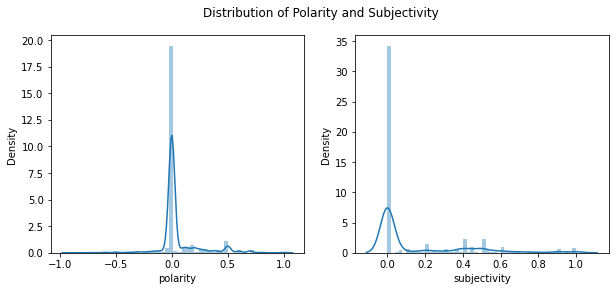

In [43]:
## Visualizing Polarity and Subjectivity

plt.rcParams['figure.figsize'] = (10, 4)

plt.subplot(1, 2, 1)
sns.distplot(df['polarity'])

plt.subplot(1, 2, 2)
sns.distplot(df['subjectivity'])

plt.suptitle('Distribution of Polarity and Subjectivity')
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


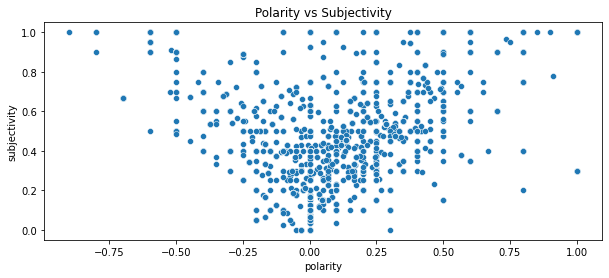

In [44]:
# lets check relation between Polarity and Subjectivity

sns.scatterplot(df['polarity'], df['subjectivity'])
plt.title('Polarity vs Subjectivity')
plt.show()

<AxesSubplot:>

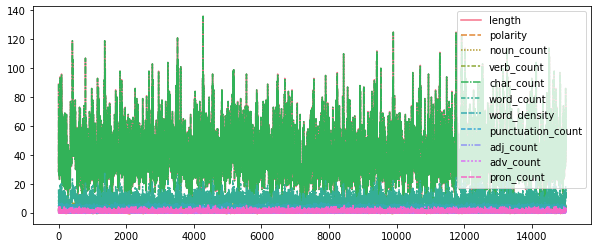

In [45]:
sns.lineplot(data=df.drop(['subjectivity'], axis=1))

<AxesSubplot:>

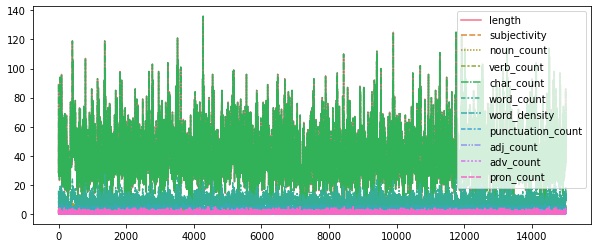

In [46]:
sns.lineplot(data=df.drop(['polarity'], axis=1))

(array([1.000e+00, 3.000e+00, 0.000e+00, 2.000e+01, 4.800e+01, 1.000e+00,
        5.900e+01, 4.100e+01, 1.400e+01, 9.100e+01, 6.200e+01, 1.520e+02,
        1.460e+02, 3.080e+02, 1.111e+04, 3.830e+02, 3.690e+02, 4.050e+02,
        4.230e+02, 1.100e+02, 1.880e+02, 2.400e+01, 6.310e+02, 1.580e+02,
        3.000e+00, 1.730e+02, 3.400e+01, 1.000e+00, 2.000e+00, 4.000e+01]),
 array([-0.9       , -0.83666667, -0.77333333, -0.71      , -0.64666667,
        -0.58333333, -0.52      , -0.45666667, -0.39333333, -0.33      ,
        -0.26666667, -0.20333333, -0.14      , -0.07666667, -0.01333333,
         0.05      ,  0.11333333,  0.17666667,  0.24      ,  0.30333333,
         0.36666667,  0.43      ,  0.49333333,  0.55666667,  0.62      ,
         0.68333333,  0.74666667,  0.81      ,  0.87333333,  0.93666667,
         1.        ]),
 <BarContainer object of 30 artists>)

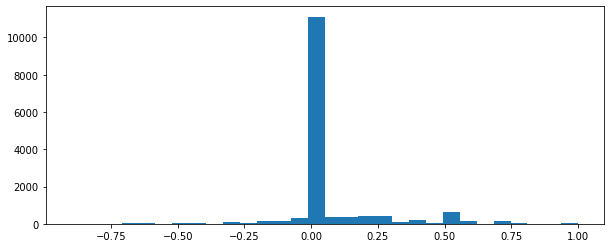

In [47]:
plt.hist(df["polarity"], bins = 30)

(array([1.0274e+04, 3.9000e+01, 1.5400e+02, 1.8700e+02, 4.1000e+01,
        7.2000e+01, 4.2600e+02, 1.4700e+02, 4.7000e+01, 2.0400e+02,
        9.5000e+01, 1.7600e+02, 6.9500e+02, 2.9500e+02, 4.0000e+01,
        6.8200e+02, 1.9200e+02, 2.2000e+01, 3.2700e+02, 7.3000e+01,
        7.4000e+01, 8.4000e+01, 1.1200e+02, 8.0000e+00, 3.1000e+01,
        1.2000e+01, 4.5000e+01, 1.7000e+02, 4.0000e+01, 2.3600e+02]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

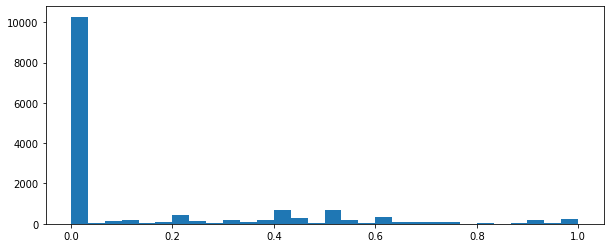

In [48]:
plt.hist(df["subjectivity"], bins = 30)

(array([10467.,   300.,   745.,   350.,  1030.,  1006.,   428.,   140.,
           88.,   446.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

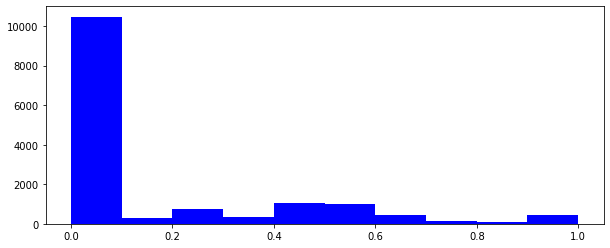

In [49]:
plt.hist(df['subjectivity'], color = 'b')

In [50]:
fig = px.scatter_3d(df.iloc[:500], x='polarity', y='subjectivity', z='subjectivity',
                    color='polarity')
fig.show()
